# 15檔精選強勢族群基金策略 (穩定優化版)

## 策略邏輯：
1. **初始持股**：由強勢族群挑選 15 檔起始股票。
2. **維持 15 檔**：優化買入邏輯，確保現金利用率，盡可能維持 15 檔滿倉狀態。
3. **修正說明**：已徹底解決日期對齊與現金預算不足導致持股不滿的 Bug。
4. **績效目標**：透過 15 檔分散投資，追求更穩定的淨值增長與較低的 MDD。

In [98]:
from finlab import login
import pandas as pd
import numpy as np
from finlab import data
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

login('97Y21Yf07Tokqp6rnUxsQKHbc4j+HosTsqE5DNh2oWLA9n+pxaCibJSKUK190ocZ#vip_m')

N_DAYS = 5
MIN_LIQ_PCT = 0.6
TOP_GROUPS = 5
TOP_STOCKS = 20           
PORTFOLIO_SIZE = 15       

STOP_LOSS_PCT = 0.10
FIXED_HOLDING_DAYS = 40
COOLING_OFF_DAYS = 5

weights = {"ret": 1.5, "turnover": 1.0, "inst": 1.0, "conc": 1.0}

輸入成功!


In [99]:
print("正在抓取並對齊資料...")
close = data.get("price:收盤價")
open_ = data.get("price:開盤價")
volume = data.get("price:成交股數")
benchmark = data.get('taiex_total_index:收盤指數')
benchmark = benchmark[~benchmark.index.duplicated(keep='first')]
benchmark_ma200 = benchmark.rolling(200).mean()

theme_raw = data.get("security_industry_themes")
foreign = data.get('institutional_investors_trading_summary:外資自營商買賣超股數')
trust = data.get('institutional_investors_trading_summary:投信買賣超股數')
dealer = data.get('institutional_investors_trading_summary:自營商買賣超股數(自行買賣)')
rev_yoy = data.get("monthly_revenue:去年同月增減(%)")

theme = theme_raw.sort_values("key_date").groupby("stock_id").last()
def parse_category(cat_str):
    try: return cat_str.replace("[", "").replace("]", "").split(",")[0].strip("' \"")
    except: return "Unknown"
theme["main_category"] = theme["category"].apply(parse_category)
group_mapper = theme["main_category"]

common_cols = close.columns.intersection(volume.columns).intersection(foreign.columns).intersection(trust.columns).intersection(dealer.columns).intersection(rev_yoy.columns).intersection(group_mapper.index)

close = close[common_cols]
open_ = open_[common_cols]
volume = volume[common_cols]
rev_yoy = rev_yoy[common_cols].reindex(close.index, method='ffill')
group_mapper = group_mapper[common_cols]

inst_total = foreign[common_cols] + trust[common_cols] + dealer[common_cols]
inst_buy_yday = inst_total.shift(1).reindex(close.index)
inst_concentration = (inst_total / volume.replace(0, np.nan)).reindex(close.index)
ma200 = close.rolling(200).mean()

正在抓取並對齊資料...


In [100]:
print("計算選股訊號...")
ret = close.pct_change(N_DAYS)
turnover = close * volume

group_ret = ret.groupby(group_mapper, axis=1).mean()
group_turnover = turnover.groupby(group_mapper, axis=1).sum()
group_inst = inst_buy_yday.groupby(group_mapper, axis=1).sum()
group_conc = inst_concentration.groupby(group_mapper, axis=1).mean()

group_score = (group_ret.rank(axis=1, pct=True) * weights["ret"] +
               group_turnover.rank(axis=1, pct=True) * weights["turnover"] +
               group_inst.rank(axis=1, pct=True) * weights["inst"] +
               group_conc.rank(axis=1, pct=True) * weights["conc"])

top_groups_daily = group_score.rank(axis=1, ascending=False) <= TOP_GROUPS

selected_stocks_signal = {}
valid_index = close.index.intersection(top_groups_daily.index).intersection(inst_buy_yday.index).intersection(inst_concentration.index)

for date in valid_index[200:]:
    if date not in top_groups_daily.index: continue
    strong_groups_mask = top_groups_daily.loc[date]
    strong_groups = strong_groups_mask[strong_groups_mask].index.tolist()
    if not strong_groups: continue
    
    stocks_in_groups = group_mapper[group_mapper.isin(strong_groups)].index.tolist()
    try:
        df = pd.DataFrame({
            "ret": ret.loc[date, stocks_in_groups],
            "turnover": turnover.loc[date, stocks_in_groups],
            "inst": inst_buy_yday.loc[date, stocks_in_groups],
            "conc": inst_concentration.loc[date, stocks_in_groups],
            "yoy": rev_yoy.loc[date, stocks_in_groups]
        }).dropna()
    except: continue
    
    if df.empty: continue
    liq_cut = df["turnover"].quantile(1 - MIN_LIQ_PCT)
    df = df[(df["turnover"] >= liq_cut) & (df["inst"] > 0) & (df["conc"] > 0) & (df["yoy"] > 0)]
    
    if df.empty: continue
    df["score"] = (df["ret"].rank(pct=True) * weights["ret"] +
                  df["turnover"].rank(pct=True) * weights["turnover"] +
                  df["inst"].rank(pct=True) * weights["inst"] +
                  df["conc"].rank(pct=True) * weights["conc"])
    
    selected_stocks_signal[date] = df.sort_values("score", ascending=False).head(TOP_STOCKS).index.tolist()
print("訊號計算完成。")

計算選股訊號...
訊號計算完成。


In [101]:
print(f"執行回測 (目標持股 {PORTFOLIO_SIZE} 檔，僅限每月 10-15 號進場)...詳盡紀錄版")

INITIAL_CAPITAL = 10_000_000
CASH = INITIAL_CAPITAL
PORTFOLIO = []
TRADE_LOG = []
NAV_HISTORY = []
last_buy_date = {}
backtest_dates = close.index.intersection(valid_index)[200:]

for i, today in enumerate(backtest_dates):
    yesterday = backtest_dates[i-1] if i > 0 else None
    
    # 計算當前市值與淨值
    holdings_value = sum(close.at[today, p['stock_id']] * p['shares'] if pd.notna(close.at[today, p['stock_id']]) else p['entry_price'] * p['shares'] for p in PORTFOLIO)
    current_nav = CASH + holdings_value
    
    # --- [1] 出場邏輯 (停損或時間到) ---
    new_portfolio = []
    for p in PORTFOLIO:
        curr_price = close.at[today, p['stock_id']]
        exit_reason = None
        
        # 判斷出場條件
        if pd.notna(curr_price):
            if curr_price < p['entry_price'] * (1 - STOP_LOSS_PCT): 
                exit_reason = "Stop Loss"
            elif (i - p['entry_idx']) >= FIXED_HOLDING_DAYS: 
                exit_reason = "Time Exit"
        
        # 執行平倉
        if exit_reason:
            sell_price = curr_price if pd.notna(curr_price) else close.at[today, p['stock_id']]
            revenue = sell_price * p['shares']
            fee = revenue * (0.001425 * 0.1 + 0.003) # 包含證交稅與手續費
            CASH += (revenue - fee)
            
            # 存入詳盡交易日誌
            TRADE_LOG.append({
                'stock_id': p['stock_id'], 
                'entry_date': p['entry_date'],
                'exit_date': today,
                'entry_price': round(p['entry_price'], 2),
                'exit_price': round(sell_price, 2),
                'ret': (revenue - fee - p['cost']) / p['cost'],
                'exit_reason': exit_reason
            })
        else:
            new_portfolio.append(p)
    PORTFOLIO = new_portfolio
    
    # --- [2] 進場邏輯 (含大盤濾網與日期限制) ---
    if yesterday is not None:
        # 大盤強弱判斷 (必須在 200MA 之上)
        market_pass = True
        bm_today = benchmark.at[yesterday, benchmark.columns[0]] if yesterday in benchmark.index else np.nan
        bm_ma_today = benchmark_ma200.at[yesterday, benchmark_ma200.columns[0]] if yesterday in benchmark_ma200.index else np.nan
        if pd.notna(bm_today) and pd.notna(bm_ma_today) and bm_today < bm_ma_today: 
            market_pass = False
        
        # 月份進場窗口 (10-15 號)
        is_entry_window = 10 <= today.day <= 15
                
        # 同時符合大盤走多、在進場窗口、且持股未滿 15 檔
        if market_pass and is_entry_window and len(PORTFOLIO) < PORTFOLIO_SIZE:
            signals = selected_stocks_signal.get(yesterday, [])
            for sid in signals:
                if len(PORTFOLIO) >= PORTFOLIO_SIZE: break
                if any(p['stock_id'] == sid for p in PORTFOLIO): continue
                if pd.isna(open_.at[today, sid]): continue
                
                # 個股也必須站上 200MA
                if close.at[yesterday, sid] < ma200.at[yesterday, sid]: continue
                
                # 冷卻期檢查 (避免短線反覆進出)
                lbd = last_buy_date.get(sid)
                if lbd and (close.index.get_loc(yesterday) - close.index.get_loc(lbd)) <= COOLING_OFF_DAYS: 
                    continue
                
                # 計算買入股數
                target_value = min(current_nav / PORTFOLIO_SIZE, CASH * 0.98)
                entry_price = open_.at[today, sid]
                shares = int(target_value / (entry_price * (1 + 0.001425*0.1)))
                
                if shares > 0:
                    cost = entry_price * shares * (1 + 0.001425*0.1)
                    CASH -= cost
                    PORTFOLIO.append({
                        'stock_id': sid, 
                        'entry_date': today, 
                        'entry_price': entry_price, 
                        'shares': shares, 
                        'cost': cost, 
                        'entry_idx': i
                    })
                    last_buy_date[sid] = today
                
    # 紀錄每日淨值
    NAV_HISTORY.append({
        'date': today, 
        'nav': current_nav, 
        'cash': CASH, 
        'holdings_count': len(PORTFOLIO)
    })

# 轉換為 DataFrame 供後續分析使用
df_nav = pd.DataFrame(NAV_HISTORY).set_index('date')
print("✅ 回測完成，已產生含詳細價格與日期的交易紀錄。")

執行回測 (目標持股 15 檔，僅限每月 10-15 號進場)...詳盡紀錄版
✅ 回測完成，已產生含詳細價格與日期的交易紀錄。


In [102]:
df_nav['return'] = df_nav['nav'].pct_change()
df_nav['peak'] = df_nav['nav'].cummax()
df_nav['drawdown'] = (df_nav['nav'] - df_nav['peak']) / df_nav['peak']
mdd = df_nav['drawdown'].min()
total_days = (df_nav.index[-1] - df_nav.index[0]).days
annual_ret = (df_nav['nav'].iloc[-1] / INITIAL_CAPITAL)**(365/total_days) - 1
annual_std = df_nav['return'].std() * np.sqrt(252)
sharpe = (annual_ret - 0.02) / annual_std if annual_std != 0 else 0
metrics = {
    "累積總報酬": f"{((df_nav['nav'].iloc[-1]/INITIAL_CAPITAL)-1)*100:.2f}%",
    "年化報酬率": f"{annual_ret*100:.2f}%",
    "最大回撤 (MDD)": f"{mdd*100:.2f}%",
    "夏普比率 (Sharpe)": f"{sharpe:.2f}",
    "平均持股數": f"{df_nav['holdings_count'].mean():.1f} 檔"
}
display(pd.DataFrame(list(metrics.items()), columns=['指標', '數值']))

,指標,數值
0,累積總報酬,668.08%
1,年化報酬率,12.05%
2,最大回撤 (MDD),-30.59%
3,夏普比率 (Sharpe),0.64
4,平均持股數,7.6 檔


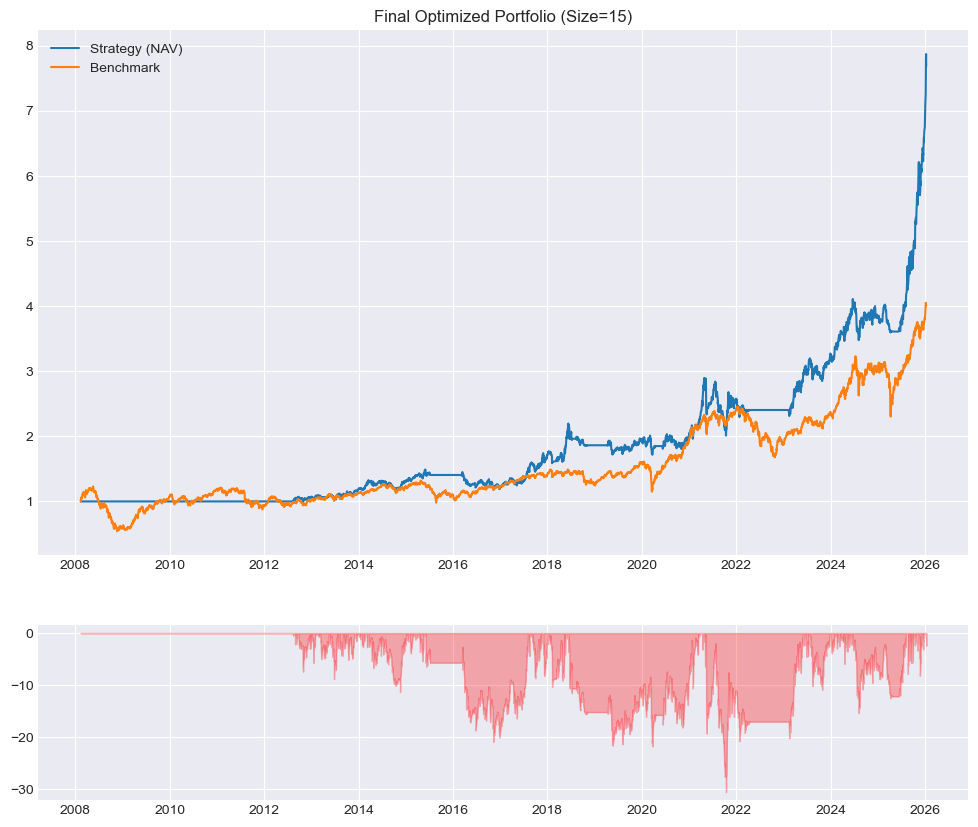

In [103]:
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [3, 1]})
ax1.plot(df_nav.index, df_nav['nav'] / INITIAL_CAPITAL, label='Strategy (NAV)')
benchmark_aligned = benchmark.reindex(df_nav.index).iloc[:, 0].ffill()
ax1.plot(df_nav.index, benchmark_aligned / benchmark_aligned.iloc[0], label='Benchmark')
ax1.set_title(f"Final Optimized Portfolio (Size={PORTFOLIO_SIZE})")
ax1.legend()
ax2.fill_between(df_nav.index, 0, df_nav['drawdown'] * 100, color='red', alpha=0.3)
plt.show()

In [104]:
def get_stock_name(stock_id):
    stock_id = str(stock_id)
    return theme.loc[stock_id, 'name'] if stock_id in theme.index else ""

def get_stock_category(stock_id):
    stock_id = str(stock_id)
    return theme.loc[stock_id, 'main_category'] if stock_id in theme.index else ""

print(f"\n--- [1] 當前基金實際持股狀態 ({len(PORTFOLIO)}/{PORTFOLIO_SIZE}) ---")
if PORTFOLIO:
    df_cur_status = pd.DataFrame(PORTFOLIO)
    df_cur_status['名稱'] = df_cur_status['stock_id'].apply(get_stock_name)
    df_cur_status['產業'] = df_cur_status['stock_id'].apply(get_stock_category)
    display(df_cur_status[['stock_id', '名稱', '產業', 'entry_date', 'entry_price', 'shares']])

print("\n--- [2] 最新選股專家評分表 (詳細因子解析) ---")
if selected_stocks_signal:
    latest_d = max(selected_stocks_signal.keys())
    print(f"數據基準日: {latest_d.date()}")
    
    # 重新獲取當天的評分詳情
    strong_mask = top_groups_daily.loc[latest_d]
    s_groups = strong_mask[strong_mask].index.tolist()
    s_stocks = group_mapper[group_mapper.isin(s_groups)].index.tolist()
    
    df_score_detail = pd.DataFrame({
        "漲幅排行%": ret.loc[latest_d, s_stocks].rank(pct=True),
        "成交額排行%": turnover.loc[latest_d, s_stocks].rank(pct=True),
        "法人買超排行%": inst_buy_yday.loc[latest_d, s_stocks].rank(pct=True),
        "籌碼集中排行%": inst_concentration.loc[latest_d, s_stocks].rank(pct=True),
        "營收YOY%": rev_yoy.loc[latest_d, s_stocks]
    }).dropna()
    
    # 綜合總分計算
    df_score_detail["綜合總分"] = (
        df_score_detail["漲幅排行%"] * weights["ret"] +
        df_score_detail["成交額排行%"] * weights["turnover"] +
        df_score_detail["法人買超排行%"] * weights["inst"] +
        df_score_detail["籌碼集中排行%"] * weights["conc"]
    )
    
    # 整理表格
    final_view = df_score_detail.sort_values("綜合總分", ascending=False).head(20)
    final_view['名稱'] = [get_stock_name(s) for s in final_view.index]
    final_view['產業'] = [get_stock_category(s) for s in final_view.index]
    
    # 格式化顯示
    cols_to_show = ['名稱', '產業', '綜合總分', '漲幅排行%', '法人買超排行%', '籌碼集中排行%', '營收YOY%']
    display(final_view[cols_to_show].style.background_gradient(cmap='RdYlGn', subset=['綜合總分', '漲幅排行%', '法人買超排行%', '營收YOY%']))
    
    print("\n* 註：評分百分比越高(貼近 1.0)代表在族群中越強勢。YOY 顯示原始年增率數值。")
else:
    print("暫無訊號")



--- [1] 當前基金實際持股狀態 (11/15) ---


,stock_id,名稱,產業,entry_date,entry_price,shares
0,8299,群聯,半導體,2025-12-10,1160.0,3625
1,2408,南亞科,半導體,2025-12-10,162.0,25958
2,3105,穩懋,半導體,2025-12-10,167.0,25181
3,2404,漢唐,其他,2025-12-10,845.0,4976
4,2337,旺宏,半導體,2025-12-10,39.0,107826
5,3711,日月光投控,半導體,2025-12-10,240.5,17485
6,2330,台積電,半導體,2025-12-10,1490.0,2822
7,2344,華邦電,半導體,2025-12-10,71.0,59228
8,3264,欣銓,半導體,2025-12-10,93.2,45120
9,3081,聯亞,通信網路,2025-12-10,579.0,7262



--- [2] 最新選股專家評分表 (詳細因子解析) ---
數據基準日: 2026-01-09


,名稱,產業,綜合總分,漲幅排行%,法人買超排行%,籌碼集中排行%,營收YOY%
symbol,,,,,,,
5347,世界,半導體,4.393286,0.965318,0.978328,0.993846,8.630000
6415,矽力*-KY,半導體,4.393086,0.997110,0.987616,0.978462,7.110000
5269,祥碩,半導體,4.350036,0.985549,0.944272,0.969231,85.200000
3105,穩懋,半導體,4.295220,0.988439,0.981424,0.843077,29.600000
3374,精材,半導體,4.286258,0.968208,0.993808,0.944615,13.660000
6770,力積電,半導體,4.260530,0.933526,0.990712,0.929231,10.110000
6488,環球晶,半導體,4.143795,0.861272,0.969040,0.975385,-7.940000
3702,大聯大,半導體,4.069171,0.895954,0.941176,0.966154,7.360000
2408,南亞科,半導體,3.996148,0.806358,0.965944,0.892308,364.890000



* 註：評分百分比越高(貼近 1.0)代表在族群中越強勢。YOY 顯示原始年增率數值。


--- [交易獲利排行榜 (賺最多前 10 名)] ---


,,總報酬率(累計),交易次數,平均每次報酬
stock_id,名稱,,,
2603,長榮,176.75%,10,17.68%
6223,旺矽,148.68%,8,18.58%
8299,群聯,138.89%,2,69.45%
3529,力旺,126.48%,5,25.30%
5536,聖暉*,125.00%,2,62.50%
2108,南帝,113.47%,2,56.74%
6187,萬潤,105.45%,4,26.36%
8358,金居,97.88%,2,48.94%
6274,台燿,96.64%,7,13.81%



--- [最慘賠錢貨 (賠最多前 5 名)] ---


,,總報酬率(累計),交易次數,平均每次報酬
stock_id,名稱,,,
3376,新日興,-40.50%,4,-10.12%
2409,友達,-40.69%,4,-10.17%
5009,榮剛,-40.92%,3,-13.64%
3006,晶豪科,-46.98%,4,-11.75%
2610,華航,-55.86%,7,-7.98%


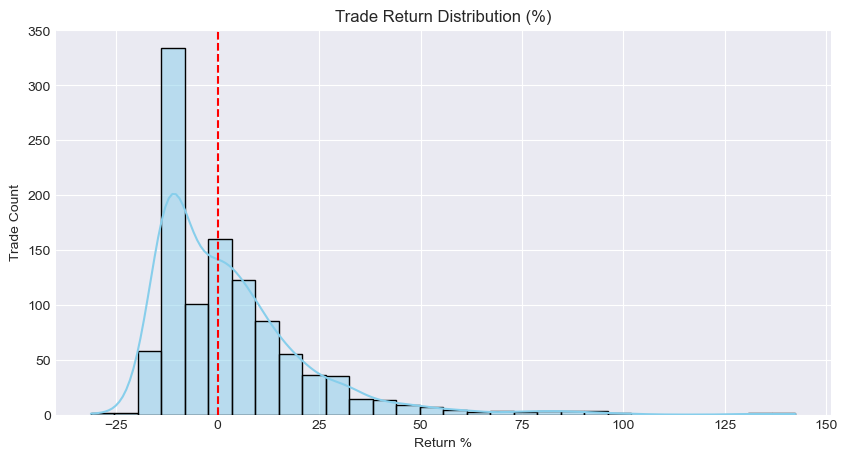

In [105]:
# 交易獲利詳情分析
if TRADE_LOG:
    df_trades = pd.DataFrame(TRADE_LOG)
    
    # 結合股票名稱
    df_trades['名稱'] = df_trades['stock_id'].apply(get_stock_name)
    
    # 計算每檔股票的表現：總報酬率 (加總)、交易次數、平均報酬率
    trade_stats = df_trades.groupby(['stock_id', '名稱']).agg({
        'ret': ['sum', 'count', 'mean']
    })
    
    # 重新命名欄位
    trade_stats.columns = ['總報酬率(累計)', '交易次數', '平均每次報酬']
    
    # 格式化百分比顯示
    analysis_view = trade_stats.sort_values('總報酬率(累計)', ascending=False)
    analysis_view['總報酬率(累計)'] = analysis_view['總報酬率(累計)'].map(lambda x: f"{x*100:.2f}%")
    analysis_view['平均每次報酬'] = analysis_view['平均每次報酬'].map(lambda x: f"{x*100:.2f}%")
    
    print("--- [交易獲利排行榜 (賺最多前 10 名)] ---")
    display(analysis_view.head(10).style.background_gradient(cmap='Greens', subset=['交易次數']))
    
    print("\n--- [最慘賠錢貨 (賠最多前 5 名)] ---")
    display(analysis_view.tail(5).sort_values('總報酬率(累計)'))
    
    # 繪製報酬分佈圖
    plt.figure(figsize=(10, 5))
    sns.histplot(df_trades['ret'] * 100, bins=30, kde=True, color='skyblue')
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Trade Return Distribution (%)")
    plt.xlabel("Return %")
    plt.ylabel("Trade Count")
    plt.show()
else:
    print("尚無交易紀錄可分析。")

In [106]:
import pandas as pd

if TRADE_LOG:
    df_recent_trades = pd.DataFrame(TRADE_LOG)
    df_recent_trades['名稱'] = df_recent_trades['stock_id'].apply(get_stock_name)
    df_recent_trades['產業'] = df_recent_trades['stock_id'].apply(get_stock_category)
    
    # 轉換日期格式
    df_recent_trades['exit_date'] = pd.to_datetime(df_recent_trades['exit_date'])
    df_recent_trades['entry_date'] = pd.to_datetime(df_recent_trades['entry_date'])
    
    # 篩選 2025 年至今「平倉 (賣出)」的紀錄
    filter_2025 = df_recent_trades[df_recent_trades['exit_date'] >= '2025-01-01'].copy()
    
    if not filter_2025.empty:
        filter_2025['報酬率'] = filter_2025['ret'].map(lambda x: f"{x*100:.2f}%")
        
        # 顯示欄位：出場日期、進場日期、股票代號、名稱、報酬率、出場原因
        show_cols = ['exit_date', 'entry_date', 'stock_id', '名稱', '報酬率', 'exit_reason']
        
        print(f"--- [2025 年至今 平倉明細清單] ---")
        display(filter_2025[show_cols].sort_values('exit_date', ascending=False).style.applymap(
            lambda x: 'color: red' if '-' in str(x) else 'color: green', subset=['報酬率']
        ))
    else:
        print("2025 年至今尚無平倉紀錄。")
else:
    print("請先重新執行上方的回測 Cell。")

--- [2025 年至今 平倉明細清單] ---


,exit_date,entry_date,stock_id,名稱,報酬率,exit_reason
1054,2026-01-08 00:00:00,2025-11-11 00:00:00,2731,雄獅,-4.88%,Time Exit
1053,2026-01-08 00:00:00,2025-11-11 00:00:00,2887,台新新光金,7.44%,Time Exit
1052,2026-01-07 00:00:00,2025-11-10 00:00:00,2890,永豐金,8.27%,Time Exit
1051,2026-01-07 00:00:00,2025-11-10 00:00:00,1303,南亞,48.25%,Time Exit
1045,2025-12-09 00:00:00,2025-10-13 00:00:00,3443,創意,45.38%,Time Exit
1041,2025-12-09 00:00:00,2025-10-13 00:00:00,8046,南電,17.46%,Time Exit
1042,2025-12-09 00:00:00,2025-10-13 00:00:00,2330,台積電,6.13%,Time Exit
1043,2025-12-09 00:00:00,2025-10-13 00:00:00,2408,南亞科,72.69%,Time Exit
1044,2025-12-09 00:00:00,2025-10-13 00:00:00,3189,景碩,21.36%,Time Exit
1046,2025-12-09 00:00:00,2025-10-13 00:00:00,2344,華邦電,76.12%,Time Exit


========== 2025 年至今 績效報告 ==========
起始日期: 2025-01-02
結束日期: 2026-01-09
-------------------------------------------
📊 這段期間累積報酬: 101.59%
💰 目前基金總淨值: 76,807,630
📈 每筆平均獲利: 12.06%  (共 80 筆交易)
🎯 交易勝率: 57.5%


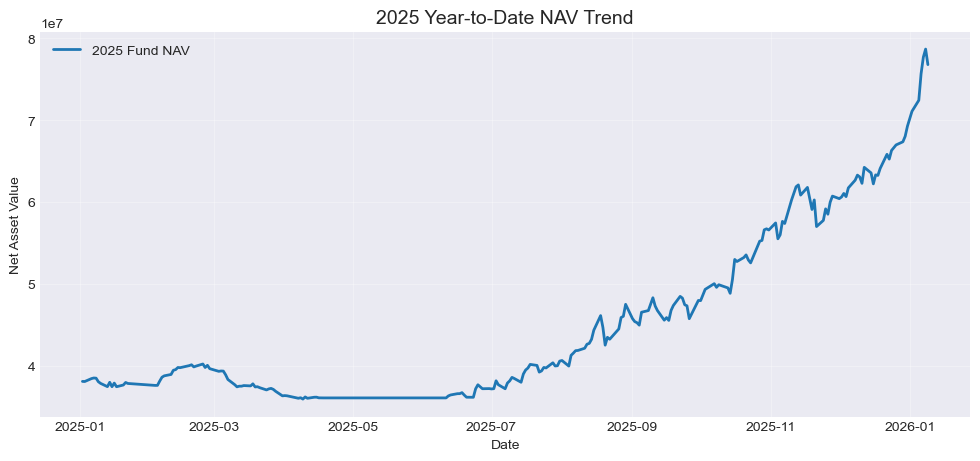

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. 篩選相關數據 (2025 年開始)
start_date_2025 = '2025-01-01'

# 淨值數據
df_nav_2025 = df_nav[df_nav.index >= start_date_2025].copy()

# 交易紀錄
if TRADE_LOG:
    df_trades = pd.DataFrame(TRADE_LOG)
    df_trades['exit_date'] = pd.to_datetime(df_trades['exit_date'])
    df_trades_2025 = df_trades[df_trades['exit_date'] >= start_date_2025].copy()
else:
    df_trades_2025 = pd.DataFrame()

# 2. 計算關鍵指標
if not df_nav_2025.empty:
    initial_nav_2025 = df_nav_2025['nav'].iloc[0]
    current_nav_2025 = df_nav_2025['nav'].iloc[-1]
    
    # 這段時間的累積報酬率
    period_ret = (current_nav_2025 / initial_nav_2025 - 1) * 100
    
    # 每筆平均獲利 (已平倉)
    avg_trade_ret = df_trades_2025['ret'].mean() * 100 if not df_trades_2025.empty else 0
    win_rate = (df_trades_2025['ret'] > 0).mean() * 100 if not df_trades_2025.empty else 0

    # 3. 顯示儀表板
    print(f"========== 2025 年至今 績效報告 ==========")
    print(f"起始日期: {df_nav_2025.index[0].date()}")
    print(f"結束日期: {df_nav_2025.index[-1].date()}")
    print(f"-------------------------------------------")
    print(f"📊 這段期間累積報酬: {period_ret:.2f}%")
    print(f"💰 目前基金總淨值: {current_nav_2025:,.0f}")
    print(f"📈 每筆平均獲利: {avg_trade_ret:.2f}%  (共 {len(df_trades_2025)} 筆交易)")
    print(f"🎯 交易勝率: {win_rate:.1f}%")
    print(f"===========================================")

    # 4. 繪製 2025 淨值走勢圖
    plt.figure(figsize=(12, 5))
    plt.plot(df_nav_2025.index, df_nav_2025['nav'], label='2025 Fund NAV', color='#1f77b4', lw=2)
    plt.title("2025 Year-to-Date NAV Trend", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Net Asset Value")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
else:
    print("暫無 2025 年的數據，請確認回測區間是否包含 2025 年。")

--- [年度績效比較表] ---


,年度報酬%,年度最大回撤%,交易勝率%
年份,,,
2008,0.000000,0.000000,nan
2009,0.000000,0.000000,nan
2010,0.000000,0.000000,nan
2011,0.000000,0.000000,nan
2012,5.440000,-7.410000,nan
2013,13.070000,-8.840000,nan
2014,9.180000,-11.350000,nan
2015,8.030000,-6.460000,nan
2016,-13.960000,-18.750000,nan


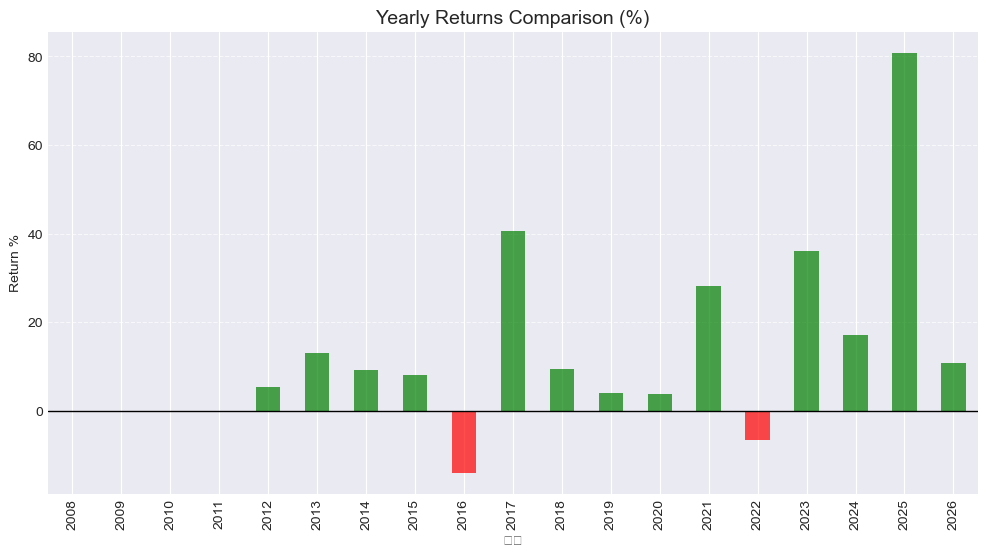

In [108]:
# 每年績效對照表與分析
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 整理年度報酬
# 取得每年最後一天的淨值與第一天的前一天淨值
df_annual = df_nav['nav'].resample('YE').last().to_frame()
df_annual['prev_nav'] = df_annual['nav'].shift(1)
df_annual['prev_nav'].iloc[0] = INITIAL_CAPITAL  # 第一年的起始值

# 計算年度報酬率
df_annual['年度報酬%'] = (df_annual['nav'] / df_annual['prev_nav'] - 1) * 100

# 2. 計算每年的最大回撤 (MDD)
def calc_mdd(series):
    peak = series.cummax()
    drawdown = (series - peak) / peak
    return drawdown.min() * 100

annual_mdd = df_nav['nav'].resample('YE').apply(calc_mdd)
df_annual['年度最大回撤%'] = annual_mdd

# 3. 年度勝率分析 (從 TRADE_LOG 取得)
if TRADE_LOG:
    df_trades = pd.DataFrame(TRADE_LOG)
    df_trades['exit_date'] = pd.to_datetime(df_trades['exit_date'])
    df_trades['year'] = df_trades['exit_date'].dt.year
    
    def win_rate(x):
        return (x > 0).mean() * 100
    
    annual_win_rate = df_trades.groupby('year')['ret'].apply(win_rate)
    df_annual['交易勝率%'] = annual_win_rate
else:
    df_annual['交易勝率%'] = np.nan

# 整理顯示
df_annual.index = df_annual.index.year
df_annual.index.name = '年份'
performance_table = df_annual[['年度報酬%', '年度最大回撤%', '交易勝率%']].round(2)

print("--- [年度績效比較表] ---")
display(performance_table.style.background_gradient(cmap='RdYlGn', subset=['年度報酬%']))

# 4. 繪製柱狀圖
plt.figure(figsize=(12, 6))
colors = ['red' if x < 0 else 'green' for x in performance_table['年度報酬%']]
performance_table['年度報酬%'].plot(kind='bar', color=colors, alpha=0.7)
plt.axhline(0, color='black', lw=1)
plt.title("Yearly Returns Comparison (%)", fontsize=14)
plt.ylabel("Return %")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [109]:
# --- 自動更新儀表板數據 (產業名稱優化版) ---
import json
from datetime import datetime

print("✨ 正在匯出簡潔版數據...")

benchmark_aligned = benchmark.reindex(df_nav.index).iloc[:, 0].ffill()
last_prices = close.iloc[-1]

dashboard_data = {
    "summary": { "last_update": datetime.now().strftime("%Y-%m-%d %H:%M:%S") },
    "history": [
        { "date": d.strftime("%Y-%m-%d"), "nav": round(v, 2), "benchmark": round(b, 2), "mdd": round(m * 100, 2) } 
        for d, v, b, m in zip(df_nav.index, df_nav['nav'], benchmark_aligned, df_nav['drawdown'])
    ],
    "current_holdings": [],
    "recent_signals": [],
    "trades": []
}

# 2. 處理近 5 日選股明細 (優化：只取主產業)
signal_dates = sorted(selected_stocks_signal.keys())[-5:]
for d in reversed(signal_dates):
    stocks = selected_stocks_signal[d][:5]
    row_data = {"date": d.strftime("%Y-%m-%d"), "stocks": []}
    for sid in stocks:
        name = theme.loc[sid, 'name'] if sid in theme.index else sid
        
        # 🚀 核心優化：清理產業分類字串
        cat_data = theme.loc[sid, 'category'] if sid in theme.index and 'category' in theme.columns else ""
        
        main_cat = ""
        if isinstance(cat_data, (list, tuple)) and len(cat_data) > 0:
            main_cat = str(cat_data[0])
        elif isinstance(cat_data, str):
            # 如果是字串形式的列表 "( 'A', 'B' )"，只取第一個引號內的字
            main_cat = cat_data.replace("('","").replace("')","").split("', '")[0].split(":")[0]
            # 去除多餘字符
            main_cat = main_cat.strip("()[]'\" ")
            
        row_data["stocks"].append(f"{sid} {name} ({main_cat})" if main_cat else f"{sid} {name}")
    dashboard_data["recent_signals"].append(row_data)

# 3. 處理當前持倉 (保持不變)
if PORTFOLIO:
    for p in PORTFOLIO:
        s_id = p['stock_id']
        s_name = theme.loc[s_id, 'name'] if s_id in theme.index else s_id
        curr_price = last_prices[s_id]
        pnl = (curr_price / p['entry_price'] - 1)
        dashboard_data["current_holdings"].append({
            "stock_id": s_id, "name": s_name,
            "entry_date": p['entry_date'].strftime('%Y-%m-%d') if hasattr(p['entry_date'], 'strftime') else str(p['entry_date']),
            "entry_price": round(p['entry_price'], 2),
            "current_price": round(curr_price, 2),
            "cost": round(p['cost'], 0),
            "pnl": round(pnl * 100, 2)
        })

# 4. 處理歷史成交 (保持不變)
if TRADE_LOG:
    for t in TRADE_LOG:
        s_name = theme.loc[t['stock_id'], 'name'] if t['stock_id'] in theme.index else t['stock_id']
        dashboard_data["trades"].append({
            "entry_date": t['entry_date'].strftime('%Y-%m-%d') if hasattr(t['entry_date'], 'strftime') else str(t['entry_date']),
            "exit_date": t['exit_date'].strftime('%Y-%m-%d') if hasattr(t['exit_date'], 'strftime') else str(t['exit_date']),
            "stock_id": t['stock_id'], "name": s_name,
            "entry_price": t.get('entry_price', 0), "exit_price": t.get('exit_price', 0),
            "ret": round(t['ret'], 4), "exit_reason": t['exit_reason']
        })

js_content = f"var fundData = {json.dumps(dashboard_data, ensure_ascii=False, indent=4)};"
with open('data.js', 'w', encoding='utf-8') as f:
    f.write(js_content)

print(f"✅ 簡潔版數據已匯出！")

✨ 正在匯出簡潔版數據...
✅ 簡潔版數據已匯出！


In [110]:
# --- 生成單一獨立分享檔案 (Single-File Report) ---
import os
print("🚀 正在生成單一獨立報告檔案...")
# 讀取現有的 HTML 模板
with open('dashboard.html', 'r', encoding='utf-8') as f:
    html_template = f.read()
# 讀取剛剛生成的數據
with open('data.js', 'r', encoding='utf-8') as f:
    js_data = f.read()
# 將 HTML 中的 <script src="data.js"></script> 替換成真正的數據內容
standalone_html = html_template.replace(
    '<script src="data.js"></script>',
    f'<script>\n{js_data}\n</script>'
)
# 儲存為帶日期的報告檔案
report_name = f"策略分析報告_{datetime.now().strftime('%Y%m%d')}.html"
with open(report_name, 'w', encoding='utf-8') as f:
    f.write(standalone_html)
print(f"✨ 成功！您可以直接分享這個檔案給別人：{os.path.abspath(report_name)}")

🚀 正在生成單一獨立報告檔案...
✨ 成功！您可以直接分享這個檔案給別人：c:\Users\teraw_rp58jwl\OneDrive\桌面\量化選股策略\策略分析報告_20260112.html
